# Real vs random clusters

In this notebook I tried to reproduce the graphs from Williams et al. 2013 paper in order to find the most optimal parameters via selecting the smaller ratio of random to real clusters. I also plotted compositions across the $d_{max}$ values and cluster sizes. The cluster composition correction was simplified:
- Fe ions column were deleted from the corrected data sets,
- Fm ions were multiplied by 0.92 as usually 8% of this peak overlaps with Fe ions,
- remaning Fm ions were added to Ni ions.

A python function based on this notebook will be added soon.

In [1]:
import xml_for_msm_with_relabelling as pgp
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import subprocess
import pandas
import time
import sys

In [2]:
output_folder = "/home/pklups/posgenpy/examples/" 
posgen_folder = "/home/pklups/apttools-posgen-code/"
pos_file_path= "" #R5083_09569-v08-roi_noOx.pos
range_file_path="" #R5083_09569-v08_noOx.rrng
random_runs = 5
# change working directory into posgen - otherwise it can't run
os.chdir(posgen_folder)

In [3]:

#Check for pos file existing, 
if not os.path.isfile(pos_file_path) and not len(pos_file_path):
    #This is hard-coded in the XML file. Could switch to -pos generation.
    pos_file_path = "posgenpyTest_easy.pos"

    #Generate the file using the example
    print('Generating synthetic pos input')

    if not subprocess.call([posgen_folder+"posgen", output_folder+"generateTestPos_easy.xml"]) == 0:
        print('Generating example pos using posgen failed')
        assert(False)
    else:
        print('Complete')

range_file_path="/home/pklups/posgenpy/examples/posgenpyTest.rrng"

if not os.path.isfile(pos_file_path):
    print(f'input pos file not found {pos_file_path}')
    assert(False)

Generating synthetic pos input
Complete


In [3]:
pos_file_path = "posgenpyTest_easy.pos"
range_file_path="/home/pklups/posgenpy/examples/posgenpyTest.rrng"

Quick fix: change the location of the dtd file in the xml file manually. In my case, the first line of posgen:
```<!DOCTYPE posscript SYSTEM "/home/pklups/apttools-posgen-code/posscript.dtd">```

### Iterate through multiple dmax values with random data

In [4]:
dmax_values = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

In [5]:
xml_files = []
output_basename="output_{i}_dmax_{dm}"
core_ions = ["Cu", "Ni"]

for i, dm in enumerate(dmax_values):
    thisName = output_basename.format(i=i,dm=dm)
    xml_output = pgp.write_xml_with_relabelling(xmlFileName=thisName,
                                                posFile=pos_file_path,
                                                rangeFile=range_file_path,
                                                coreIons=core_ions,
                                                bulkIons=["Fe"],
                                                relabelled_runs=random_runs,
                                                destination_folder=output_folder,
                                                nminV=2,
                                                dmax=dm,
                                                dtd_file_location="/home/pklups/apttools-posgen-code/"
                                  )
    output_file = output_folder + os.sep + str(thisName) + ".xml"
    xml_files.append(output_file)

TODO: change the dmax values in the folders so that they dont include full stop as it might cause some problems later

In [6]:
for x in xml_files:
    print(x)

/home/pklups/posgenpy/examples//output_0_dmax_0.2.xml
/home/pklups/posgenpy/examples//output_1_dmax_0.3.xml
/home/pklups/posgenpy/examples//output_2_dmax_0.4.xml
/home/pklups/posgenpy/examples//output_3_dmax_0.5.xml
/home/pklups/posgenpy/examples//output_4_dmax_0.6.xml
/home/pklups/posgenpy/examples//output_5_dmax_0.7.xml


```os.chdir(posgen_folder)``` is not needed. WSL can easily run posgen by using full paths.

In [7]:
# os.chdir("/home/pklups/posgenpy/")
# current_directory = os.getcwd()
# os.chdir(posgen_folder)
# print(os.getcwd())

for i, xml_file in enumerate(xml_files):
    posgen_output = subprocess.call(["./posgen", xml_file])
    print(f"File {i+1}/{len(xml_files)} analysed")
    
# os.chdir(current_directory)
# print(os.getcwd())

File 1/6 analysed
File 2/6 analysed
File 3/6 analysed
File 4/6 analysed
File 5/6 analysed
File 6/6 analysed


### Plotting threshold value
$(N_{real} - N_{rand})/N_{real}$

/home/pklups/posgenpy/xml_for_msm_with_relabelling.py:312: RuntimeWarning: invalid value encountered in true_divide
  y_values = (real_local - random_local) / real_local
/home/pklups/posgenpy/xml_for_msm_with_relabelling.py:312: RuntimeWarning: invalid value encountered in true_divide
  y_values = (real_local - random_local) / real_local
/home/pklups/posgenpy/xml_for_msm_with_relabelling.py:312: RuntimeWarning: invalid value encountered in true_divide
  y_values = (real_local - random_local) / real_local
/home/pklups/posgenpy/xml_for_msm_with_relabelling.py:312: RuntimeWarning: invalid value encountered in true_divide
  y_values = (real_local - random_local) / real_local


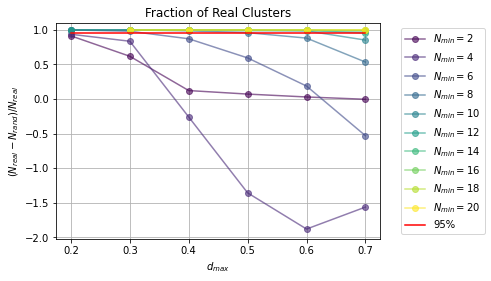

In [7]:
n_min_values = list(range(2, 21, 2))

pgp.plot_real_cluster_ratio_across_swept_param(
    swept_parameters=dmax_values,
    swept_parameter_name="$d_{max}$",
    random_runs=random_runs,
    xml_files=xml_files,
    n_min_values=n_min_values
)

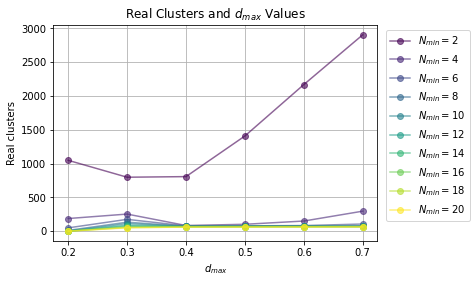

In [8]:
pgp.plot_real_clusters_across_swept_param(
    swept_parameters=dmax_values,
    swept_parameter_name="$d_{max}$",
    random_runs=random_runs,
    xml_files=xml_files,
    n_min_values=n_min_values
)

## Find optimal N_min

Find the smallest $N_{min}$ value for each file that satisfies given threshold of real clusters. Default value = 95%

In [9]:
optimal_n_min_values = pgp.find_smallest_nmin(
    swept_parameters=dmax_values,
    swept_parameter_name="d_max",
    random_runs=random_runs,
    xml_files=xml_files,
    n_min_values=list(range(1, 100, 1)) # go through evey n_min possible up to a high number
)

print(optimal_n_min_values)

d_max: 0.2 | n_min: 5 | ratio: 0.976086956521739
d_max: 0.3 | n_min: 6 | ratio: 0.9805714285714285
d_max: 0.4 | n_min: 7 | ratio: 0.9567567567567568
d_max: 0.5 | n_min: 8 | ratio: 0.96
d_max: 0.6 | n_min: 9 | ratio: 0.9546666666666666
d_max: 0.7 | n_min: 12 | ratio: 0.9549295774647887
[5, 6, 7, 8, 9, 12]


## Plotting cluster composition 

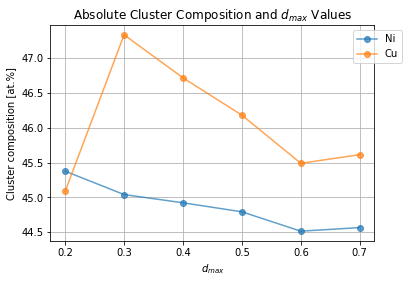

In [10]:
# retrieve the data needed from the cluster stats files for the composition plots
core_ions = ["Ni", "Cu"]

pgp.plot_cluster_composition_across_swept_param_absolute(
    swept_parameters=dmax_values,
    core_ions=core_ions,
    xml_files=xml_files,
    n_min_values_for_swept_parameters=optimal_n_min_values,
    swept_parameter_name="$d_{max}$",
    exclude_ions=None
)

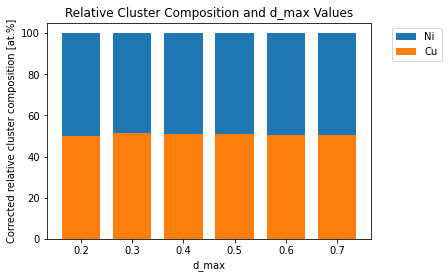

In [11]:
pgp.plot_cluster_composition_across_swept_param_relative(
    swept_parameters=dmax_values,
    core_ions=core_ions,
    xml_files=xml_files,
    n_min_values_for_swept_parameters=optimal_n_min_values,
    swept_parameter_name="d_max",
    exclude_ions=None
)

# Other graphs

These graphs are not that useful during the quick check so I didn't simplify them. I left the code in case anyone wants to play with it.


## Composition Correction

1. Removing certain elements from the calculations such as Fe.
2. Changing the amount of overlapped ions (peak 29: approx. 90% of Ni, and 10% of Fe) <- needs to be changed later to more accurate method!
3. Adding Fm to Ni column.

In [159]:
# corrected compositions by excluding certain elements from the calculations
exclude_ions = ["Fe"]
overlap_ions = {"Fm": 0.92}

In [168]:
# before reading the data and after creating pandas dataframes, drop specified columns
# retrieve the data needed from the cluster stats files for the composition plots
core_ions = ["Ni", "P", "Cu", "Mn", "Si"]

# create a new dictionary every time you run a correction to avoid correcting data more than once
corrected_compositions = {}

for i, dm in enumerate(dmax_values):
    # open the cluster stats file and create pandas dataframe
    cluster_stats_file = xml_files[i].replace(".xml", "_cluster-stats.txt")
    local_df = pandas.read_csv(cluster_stats_file, sep="\t")
    
    # insert all the corrections in here
    # exclude (matrix) ions by deleting the column
    local_df = local_df.drop(exclude_ions, axis=1)
    # lower the amount of ions for each element that has overlap with matrix ions
    for overlap_ion in overlap_ions:
        local_df[overlap_ion] = round(local_df[overlap_ion] * overlap_ions[overlap_ion])
    # transfer the overlapping ions into "original" elements
    local_df["Ni"] = local_df["Ni"] + local_df["Fm"]
    # delete the overlaping ions by multiplying by 0 to keep the total amount of ions constant
    local_df["Fm"] = local_df["Fm"] * 0
    
    # iterate through the core elements and import sums of the ions detected
    corrected_compositions[dm] = {}
    for ion in core_ions:
        corrected_compositions[dm][ion] = np.array(local_df[ion]).sum()
    
    # find total sum of all ions detected in the cluster search for the uncorrected composition
    corrected_compositions[dm]["total clusters"] = np.array(local_df.iloc[:, 3:-2]).sum()

Copying and pasting previous scripts for plotting as it's exactly the same from now.

Text(0.5, 1.0, 'Corrected Cluster composition $d_{max}$ values')

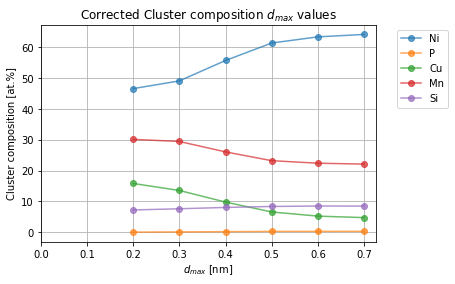

In [169]:
# plot using the data prepared 
for ion in core_ions:
    x_values = []
    y_values = []
    for i, dm in enumerate(dmax_values):
        x_values.append(dm)
        y_values.append(corrected_compositions[dm][ion]/corrected_compositions[dm]["total clusters"] * 100)
    
    plt.plot(x_values, y_values, 'o-', alpha=0.7, label=ion)

# adjust the plot    
plt.xlabel("$d_{max}$ [nm]")
plt.ylabel("Cluster composition [at.%]")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid()
plt.xlim(left=0)
# plt.ylim(top=1.1)
plt.title("Corrected Cluster composition $d_{max}$ values")

Plotting relative cluster composition will be also different due to smaller Fm content.

Text(0.5, 1.0, 'Cluster composition across different $d_{max}$ values')

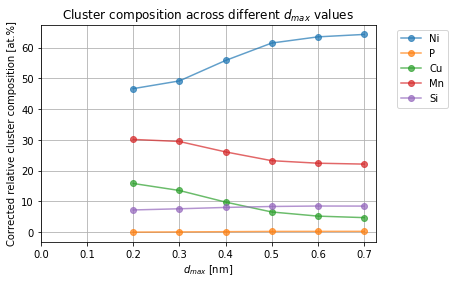

In [170]:
# find the corrected value (normalised core ion composition)
# create dictionary with place for d_max and list of core ion counts
core_ions_sum = {}
for dm in dmax_values:
    core_ions_sum[dm] = []

# iterate through the compositions data and append all ion counts into the list
for ion in core_ions:
    for i, dm in enumerate(dmax_values):
        core_ions_sum[dm].append(corrected_compositions[dm][ion])

# find the total sum of all core ions for a given d_max
for dm in core_ions_sum:
    core_ions_sum[dm] = np.array(core_ions_sum[dm]).sum()

# calculate relative composition of core ions in the clusters and plot them
for ion in core_ions:
    x_values = []
    y_values = []
    for i, dm in enumerate(dmax_values):
        x_values.append(dm)
        y_values.append(corrected_compositions[dm][ion]/core_ions_sum[dm] * 100)

    plt.plot(x_values, y_values, 'o-', alpha=0.7, label=ion)

# adjust the plot    
plt.xlabel("$d_{max}$ [nm]")
plt.ylabel("Corrected relative cluster composition [at.%]")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid()
plt.xlim(left=0)
# plt.ylim(top=1.1)
plt.title("Cluster composition across different $d_{max}$ values")

Text(0.5, 1.0, 'Cluster composition across different $d_{max}$ values')

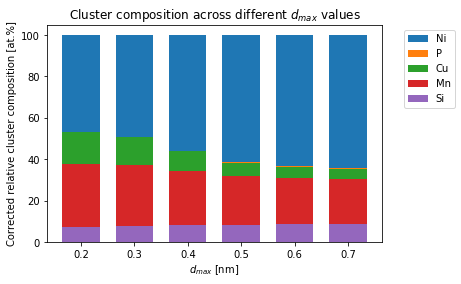

In [176]:
# the same graph but stacked bars
# calculate relative composition of core ions in the clusters and plot them
for i, ion in enumerate(core_ions):
    x_values = []
    y_values = []
    for dm in dmax_values:
        x_values.append(dm)
        y_values.append(corrected_compositions[dm][ion]/core_ions_sum[dm] * 100)

    # need to plot bar graphs on top of each other starting from 100%
    # and subtracting the values from the previous one
    # I use next value to avoid problems with labelling
    if i == 0:
        y_values_bar = np.ones(len(dmax_values)) * 100

    else:
        y_values_bar = next_values
    
    plt.bar(x_values, y_values_bar, alpha=1, label=ion, width=0.07)
    previous_values = y_values_bar
    
    next_values = y_values_bar - y_values

# adjust the plot    
plt.xlabel("$d_{max}$ [nm]")
plt.ylabel("Corrected relative cluster composition [at.%]")
plt.legend(bbox_to_anchor=(1.05, 1))
# plt.grid()
# plt.xlim(left=0)
# plt.ylim(top=1.1)
plt.title("Cluster composition across different $d_{max}$ values")

## Composition vs cluster size

For a given cluster-stat file, plot the composition across all clusters and sort them by their size.


Text(0.5, 1.0, 'Cluster composition and size')

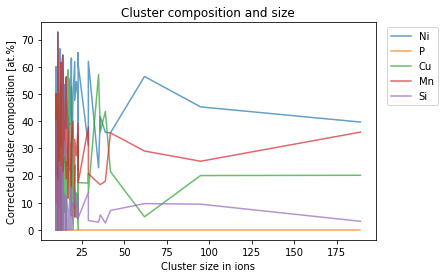

In [193]:
# corrected compositions by excluding certain elements from the calculations
exclude_ions = ["Fe"]
overlap_ions = {"Fm": 0.92}
n_min = 10

# before reading the data and after creating pandas dataframes, drop specified columns
# retrieve the data needed from the cluster stats files for the composition plots
core_ions = ["Ni", "P", "Cu", "Mn", "Si"]

# create a new dictionary every time you run a correction to avoid correcting data more than once
dfs = {}
cluster_data = {}

for i, dm in enumerate(dmax_values):
    # open the cluster stats file and create pandas dataframe
    cluster_stats_file = xml_files[i].replace(".xml", "_cluster-stats.txt")
    local_df = pandas.read_csv(cluster_stats_file, sep="\t")
    
    # insert all the corrections in here
    # exclude (matrix) ions by deleting the column
    local_df = local_df.drop(exclude_ions, axis=1)
    # lower the amount of ions for each element that has overlap with matrix ions
    for overlap_ion in overlap_ions:
        local_df[overlap_ion] = round(local_df[overlap_ion] * overlap_ions[overlap_ion])
    # transfer the overlapping ions into "original" elements
    local_df["Ni"] = local_df["Ni"] + local_df["Fm"]
    # delete the overlaping ions by multiplying by 0 to keep the total amount of ions constant
    local_df["Fm"] = local_df["Fm"] * 0
    
    # add total ions in cluster value
    local_df["Cluster Size"] = local_df.iloc[:, 3:-2].sum(axis=1)
    
    # change n_min
    local_df = local_df[local_df["Cluster Size"] >= n_min]
    
    # sort it by size
    local_df = local_df.sort_values(by="Cluster Size")
    
    
    
    # iterate through rows and find their core ions and total ions values
    for core_ion in core_ions:
        x_values = local_df["Cluster Size"]
        y_values = local_df[core_ion]/local_df["Cluster Size"] * 100
        plt.plot(x_values, y_values, "-", alpha=0.7, label=core_ion)
    
    
    break

# adjust the plot    
plt.xlabel("Cluster size in ions")
plt.ylabel("Corrected cluster composition [at.%]")
plt.legend(bbox_to_anchor=(1.2, 1))
# plt.grid()
# plt.xlim(left=0)
# plt.ylim(top=1.1)
plt.title("Cluster composition and size")

This data would be much clearer if:
- x axis showed index
- we used stacked bar chart
- we created a histogram with averaged cluster size bins

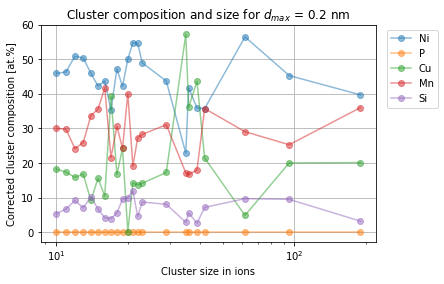

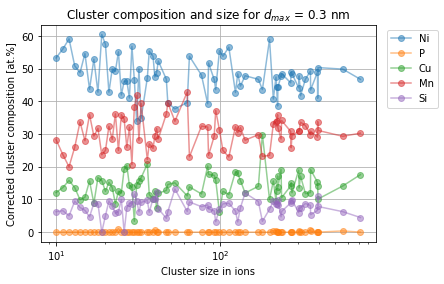

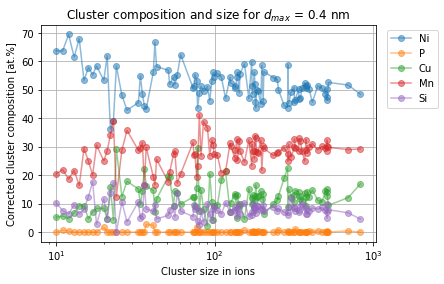

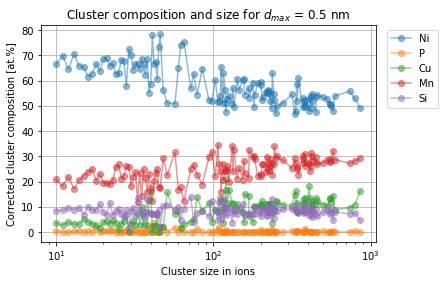

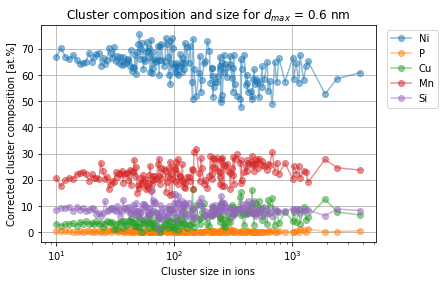

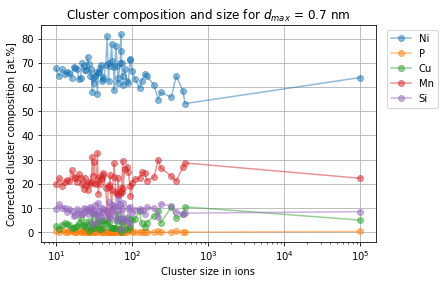

In [223]:
# corrected compositions by excluding certain elements from the calculations
exclude_ions = ["Fe"]
overlap_ions = {"Fm": 0.92}
n_min = 10

# before reading the data and after creating pandas dataframes, drop specified columns
# retrieve the data needed from the cluster stats files for the composition plots
core_ions = ["Ni", "P", "Cu", "Mn", "Si"]

# create a new dictionary every time you run a correction to avoid correcting data more than once
dfs = {}
cluster_data = {}

for i, dm in enumerate(dmax_values):
    plt.figure()
    # open the cluster stats file and create pandas dataframe
    cluster_stats_file = xml_files[i].replace(".xml", "_cluster-stats.txt")
    local_df = pandas.read_csv(cluster_stats_file, sep="\t")
    
    # insert all the corrections in here
    # exclude (matrix) ions by deleting the column
    local_df = local_df.drop(exclude_ions, axis=1)
    # lower the amount of ions for each element that has overlap with matrix ions
    for overlap_ion in overlap_ions:
        local_df[overlap_ion] = round(local_df[overlap_ion] * overlap_ions[overlap_ion])
    # transfer the overlapping ions into "original" elements
    local_df["Ni"] = local_df["Ni"] + local_df["Fm"]
    # delete the overlaping ions by multiplying by 0 to keep the total amount of ions constant
    local_df["Fm"] = local_df["Fm"] * 0
    
    # add total ions in cluster value
    local_df["Cluster Size"] = local_df.iloc[:, 3:-2].sum(axis=1)
    
    # change n_min
    local_df = local_df[local_df["Cluster Size"] >= n_min]
    
    # sort it by size
    local_df = local_df.sort_values(by="Cluster Size")
    
    
    # iterate through rows and find their core ions and total ions values
    for core_ion in core_ions:
        x_values = local_df["Cluster Size"].unique()
        y_values = np.zeros(len(x_values))
        y_std = np.zeros(len(x_values))
        
        # for each cluster size find all clusters and calculate mean Ni content with stdev
        for i2, x in enumerate(iter(x_values)):
            all_for_one_size = local_df[local_df["Cluster Size"] == x][core_ion]
            y_values[i2] = all_for_one_size.mean() / x * 100
            y_std[i2] = all_for_one_size.std() / x * 100
            # TODO: think about how to plot st dev later on
        
        plt.semilogx(x_values, y_values, "o-", alpha=0.5, label=core_ion)
    
    # adjust the plot    
    plt.xlabel("Cluster size in ions")
    plt.ylabel("Corrected cluster composition [at.%]")
    plt.legend(bbox_to_anchor=(1.2, 1))
    plt.grid()
    # plt.xlim(left=0)
    # plt.ylim(top=1.1)
    plt.title("Cluster composition and size for $d_{max}$ = %s nm"%dm)
    plt.show()
    

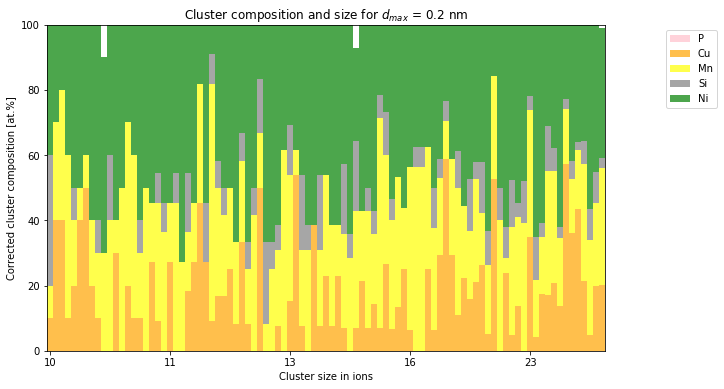

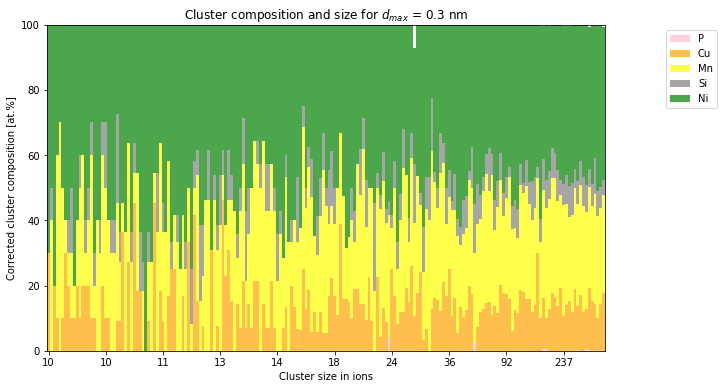

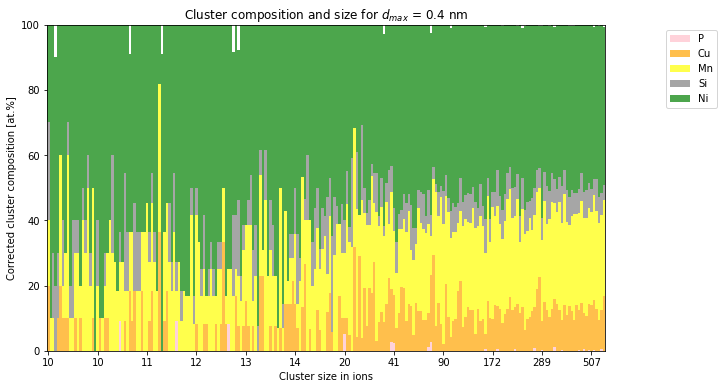

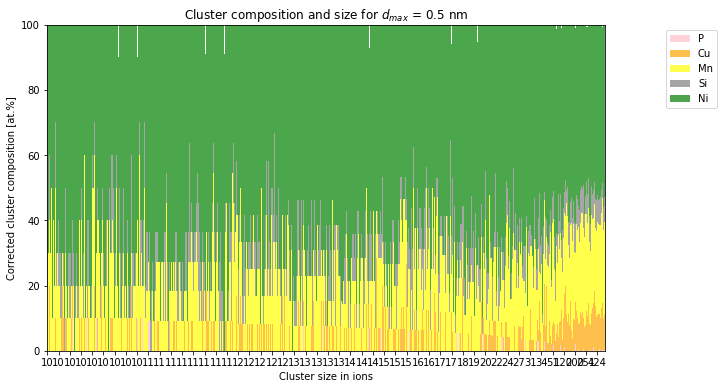

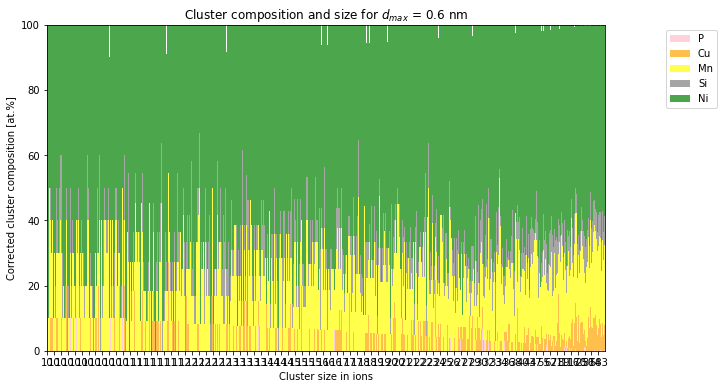

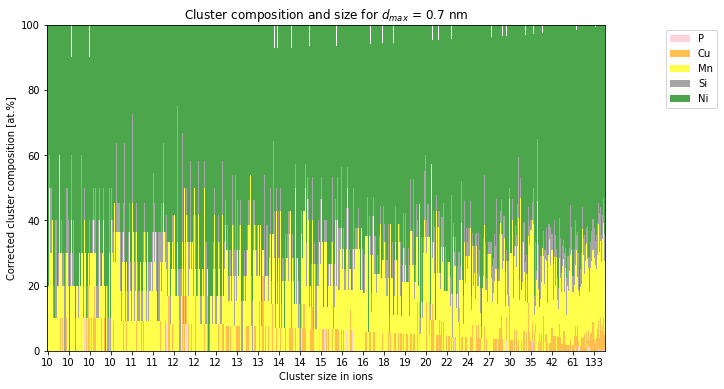

In [278]:
# same but with bar
# corrected compositions by excluding certain elements from the calculations
exclude_ions = ["Fe"]
overlap_ions = {"Fm": 0.92}
n_min = 10
core_ion_colors = {
    "Cu": "orange",
    "Ni": "green",
    "Mn": "yellow",
    "P": "pink",
    "Si": "grey"
}

# before reading the data and after creating pandas dataframes, drop specified columns
# retrieve the data needed from the cluster stats files for the composition plots
core_ions = ["P", "Cu", "Mn", "Si", "Ni"]

# create a new dictionary every time you run a correction to avoid correcting data more than once
dfs = {}
cluster_data = {}

for i, dm in enumerate(dmax_values):
    plt.figure(figsize=(10, 6))
    # open the cluster stats file and create pandas dataframe
    cluster_stats_file = xml_files[i].replace(".xml", "_cluster-stats.txt")
    local_df = pandas.read_csv(cluster_stats_file, sep="\t")
    
    # insert all the corrections in here
    # exclude (matrix) ions by deleting the column
    local_df = local_df.drop(exclude_ions, axis=1)
    # lower the amount of ions for each element that has overlap with matrix ions
    for overlap_ion in overlap_ions:
        local_df[overlap_ion] = round(local_df[overlap_ion] * overlap_ions[overlap_ion])
    # transfer the overlapping ions into "original" elements
    local_df["Ni"] = local_df["Ni"] + local_df["Fm"]
    # delete the overlaping ions by multiplying by 0 to keep the total amount of ions constant
    local_df["Fm"] = local_df["Fm"] * 0
    
    # add total ions in cluster value
    local_df["Cluster Size"] = local_df.iloc[:, 3:-2].sum(axis=1)
    
    # change n_min
    local_df = local_df[local_df["Cluster Size"] >= n_min]
    
    # sort it by size
    local_df = local_df.sort_values(by="Cluster Size")
    
    previous_y_values = []
    # iterate through rows and find their core ions and total ions values
    for i2, core_ion in enumerate(core_ions):
        cluster_size_values = local_df["Cluster Size"]
        x_values = np.arange(len(cluster_size_values))
        y_values = local_df[core_ion] / local_df["Cluster Size"] * 100
        
#         # for each cluster size find all clusters and calculate mean core ion content with stdev
#         for i3, x in enumerate(iter(x_values)):
#             all_for_one_size = local_df[local_df["Cluster Size"] == x][core_ion]
#             y_values[i3] = all_for_one_size.mean() / x * 100
#             y_std[i3] = all_for_one_size.std() / x * 100
#             # TODO: think about how to plot st dev later on
        
        if i2 == 0:
            plt.bar(x_values, y_values, width=1, alpha=0.7, label=core_ion, 
                    color=core_ion_colors[core_ion])
            previous_y_values = y_values
        else:
            plt.bar(x_values, y_values, bottom=previous_y_values, width=1, 
                    alpha=0.7, label=core_ion, color=core_ion_colors[core_ion])
            previous_y_values = previous_y_values + y_values
    
    # adjust the plot    
    plt.xlabel("Cluster size in ions")
    plt.ylabel("Corrected cluster composition [at.%]")
    
    # prepare the x axis - plot every 20th value
    tick = 20
    cluster_size_values = cluster_size_values.astype(int)
    plt.xticks(x_values[::tick], cluster_size_values[::tick])
    plt.legend(bbox_to_anchor=(1.1, 1))
#     plt.grid()
    plt.xlim(-0.5, len(y_values)-0.5)
    plt.ylim(0, 100)
    plt.title("Cluster composition and size for $d_{max}$ = %s nm"%dm)
    plt.show()
